In [ ]:
!pip install gym==0.23.1
!pip install numpy==1.24.2
!pip install torch==1.12.0
!pip install matplotlib==3.2.2

In [18]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [20]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.to(device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)



In [21]:
class DQNAgent:
    def __init__(self, state_size, action_size, seed, lr):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr)

        self.memory = ReplayBuffer(action_size, buffer_size=int(1e5), batch_size=64, seed=seed)
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)

        self.t_step = (self.t_step + 1) % 4
        if self.t_step == 0:
            if len(self.memory) > self.memory.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, gamma=0.99)

    def act(self, state, eps=0.):
        state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)

        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state_tensor)
        self.qnetwork_local.train()

        if np.random.random() > eps:
            return action_values.argmax(dim=1).item()
        else:
            return np.random.randint(self.action_size)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        Q_expected = self.qnetwork_local(states).gather(1, actions)

        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.qnetwork_local, self.qnetwork_target, tau=1e-3)

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

In [22]:
env = gym.make("CartPole-v1")

# Define training parameters
num_episodes = 1000
max_steps_per_episode = 200
epsilon_start = 1.0
epsilon_end = 0.2
epsilon_decay_rate = 0.99
gamma = 0.995
lr = 0.001
buffer_size = 10000
batch_size = 128
update_frequency = 10

input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n
new_agent = DQNAgent(input_dim, output_dim, seed=170715, lr=lr)

best_score = -np.inf
save_path = "best_dqn_model.pth"

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [23]:
for episode in range(1, num_episodes + 1):
    state = env.reset()
    epsilon = max(epsilon_end, epsilon_start * (epsilon_decay_rate ** episode))
    total_reward = 0

    for step in range(max_steps_per_episode):
        action = new_agent.act(state, epsilon)
        next_state, reward, done, _ = env.step(action)

        total_reward += reward

        new_agent.step(state, action, reward, next_state, done)

        state = next_state

        if done:
            break

    if total_reward > best_score:
        best_score = total_reward
        torch.save(new_agent.qnetwork_local.state_dict(), save_path)
        print(f"New best score {best_score} achieved at episode {episode}. Model saved!")

    if episode % update_frequency == 0:
        print(f"Episode {episode}/{num_episodes} - Best Score: {best_score} - Epsilon: {epsilon:.4f}")

print("Training completed.")


/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


New best score 21.0 achieved at episode 1. Model saved!
New best score 35.0 achieved at episode 2. Model saved!
New best score 38.0 achieved at episode 9. Model saved!
Episode 10/1000 - Best Score: 38.0 - Epsilon: 0.9044
New best score 40.0 achieved at episode 12. Model saved!
Episode 20/1000 - Best Score: 40.0 - Epsilon: 0.8179
New best score 47.0 achieved at episode 23. Model saved!
Episode 30/1000 - Best Score: 47.0 - Epsilon: 0.7397
Episode 40/1000 - Best Score: 47.0 - Epsilon: 0.6690
Episode 50/1000 - Best Score: 47.0 - Epsilon: 0.6050
New best score 53.0 achieved at episode 54. Model saved!
Episode 60/1000 - Best Score: 53.0 - Epsilon: 0.5472
Episode 70/1000 - Best Score: 53.0 - Epsilon: 0.4948
Episode 80/1000 - Best Score: 53.0 - Epsilon: 0.4475
Episode 90/1000 - Best Score: 53.0 - Epsilon: 0.4047
Episode 100/1000 - Best Score: 53.0 - Epsilon: 0.3660
Episode 110/1000 - Best Score: 53.0 - Epsilon: 0.3310
Episode 120/1000 - Best Score: 53.0 - Epsilon: 0.2994
Episode 130/1000 - Bes

In [24]:
env = gym.make("CartPole-v1")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

seed = 170715
best_model_path = "best_dqn_model.pth"

qnetwork = QNetwork(state_size, action_size, seed).to(device)
qnetwork.load_state_dict(torch.load(best_model_path, map_location=device))
qnetwork.eval()
print("Best model loaded successfully.")

def evaluate_agent(qnetwork, env, n_episodes=10, max_steps=200, render=False):
    total_rewards = []

    for episode in range(1, n_episodes + 1):
        state = env.reset()
        total_reward = 0

        for step in range(max_steps):
            if render:
                env.render()

            state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(device)
            with torch.no_grad():
                action_values = qnetwork(state_tensor)
            action = torch.argmax(action_values, dim=1).item()

            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            state = next_state

            if done:
                break

        total_rewards.append(total_reward)
        print(f"Episode {episode}: Total Reward = {total_reward}")

    avg_reward = np.mean(total_rewards)
    print(f"\nAverage Reward over {n_episodes} episodes: {avg_reward}")
    return avg_reward, total_rewards

Best model loaded successfully.


<ipython-input-24-c83f802bbeff>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  qnetwork.load_state_dict(torch.load(best_model_path, map_location=device))


Episode 1: Total Reward = 158.0
Episode 2: Total Reward = 152.0
Episode 3: Total Reward = 160.0
Episode 4: Total Reward = 189.0
Episode 5: Total Reward = 150.0
Episode 6: Total Reward = 178.0
Episode 7: Total Reward = 174.0
Episode 8: Total Reward = 184.0
Episode 9: Total Reward = 162.0
Episode 10: Total Reward = 184.0
Episode 11: Total Reward = 200.0
Episode 12: Total Reward = 184.0
Episode 13: Total Reward = 140.0
Episode 14: Total Reward = 180.0
Episode 15: Total Reward = 182.0
Episode 16: Total Reward = 178.0
Episode 17: Total Reward = 143.0
Episode 18: Total Reward = 188.0
Episode 19: Total Reward = 154.0
Episode 20: Total Reward = 144.0
Episode 21: Total Reward = 152.0
Episode 22: Total Reward = 139.0
Episode 23: Total Reward = 144.0
Episode 24: Total Reward = 145.0
Episode 25: Total Reward = 152.0
Episode 26: Total Reward = 156.0
Episode 27: Total Reward = 181.0
Episode 28: Total Reward = 169.0
Episode 29: Total Reward = 182.0
Episode 30: Total Reward = 163.0
Episode 31: Total R

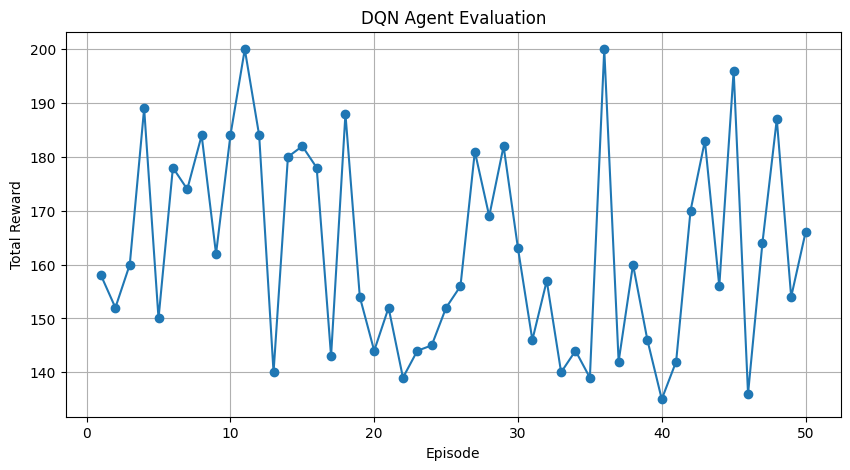

In [25]:
n_eval_episodes = 50

avg_reward, rewards = evaluate_agent(qnetwork, env, n_episodes=n_eval_episodes, render=False)

plt.figure(figsize=(10, 5))
plt.plot(range(1, n_eval_episodes + 1), rewards, marker='o')
plt.title("DQN Agent Evaluation")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

env.close()